# Working with Sentinel-2 and Copernicus API

Goal of the lecture:
1. Visualize multiple bands from the downloaded tile
1. Create an RGB image of three bands; one true-color and one false-color composite
1. Programmatically download the tile from the open and free [Copernicus Dataspace](https://dataspace.copernicus.eu/) page
1. Select a sub-region of the tile by defining a region of interest
1. Visualize the spectral signature of different land-use/land-cover classes

## Visualizing multiple bands

For simplicity, we will re-use large parts of the code from the last lab.

### Code from Lab01 Start ---

In [2]:
import requests
from tqdm.rich import tqdm
from pathlib import Path

In [1]:
# # some code from that last lab
# # Provided template to download file; not relevant for course

# def download_file_with_progress(url: str, output_file: Path):
#     """
#     Given a `url` as a String and an `output_file` as a file-path the item will
#     be downloaded and written to the `output_file`. If the `output_file` already
#     exists, it will be overwritten.
#     """
#     s = requests.Session()
#     chunk_size = 2**20  # mb
#     with s.get(url, stream=True) as resp:
#         with open(output_file, "wb") as f:
#             print(f"Saving to {output_file}")
#             for data in tqdm(
#                 resp.iter_content(chunk_size=chunk_size), 
#                 total=int(resp.headers.get("content-length", 0)) // chunk_size, 
#                 unit="MB",
#                 unit_scale=True,
#                 desc="Downloading...",
#             ):
#                 f.write(data)

In [3]:
data_path = Path("./data")
data_path.mkdir(exist_ok=True)
# For quick prototyping there is on such things as _too many_ asserts!
assert data_path.exists, "Should exist after calling mkdir!"

In [4]:
tile_name = Path("S2A_MSIL2A_20240308T100841_N0510_R022_T33UUU_20240308T143352")
output_filepath = data_path / tile_name.with_suffix(".SAFE.zip")
output_filepath

PosixPath('data/S2A_MSIL2A_20240308T100841_N0510_R022_T33UUU_20240308T143352.SAFE.zip')

In [4]:
# re-hosted file on TUB-Cloud for fast download during class ~800MB before and after unpacking
# sentinel_tile_url = "https://tubcloud.tu-berlin.de/s/2EMnZwypF2pK5XG/download/S2A_MSIL2A_20240308T100841_N0510_R022_T33UUU_20240308T143352.SAFE.zip"

#download_file_with_progress(url=sentinel_tile_url, output_file=output_filepath)

Output()

Saving to data/S2A_MSIL2A_20240308T100841_N0510_R022_T33UUU_20240308T143352.SAFE.zip


/tmp/ipykernel_630/4028588167.py:20: TqdmExperimentalWarning: rich is experimental/alpha
  for data in tqdm(


In [5]:
# import zipfile

# zipf = zipfile.ZipFile(output_filepath)
# zipf.extractall(path="data")
unzipped_dir = Path(data_path / tile_name.with_suffix(".SAFE"))
assert unzipped_dir.exists(), f"{unzipped_dir} does not exist!"

In [6]:
import rasterio
import matplotlib.pyplot as plt


class S2TileReader:
    def __init__(self, directory: Path):
        """
        Initialize the reader with a directory containing the SAFE file of a Sentinel-2 product.

        Parameters
        ----------
        directory : Path
            The directory containing the SAFE file of a Sentinel-2 product.
        """
        assert directory.is_dir(), f"{directory} is not a directory"
        self.image_files = list(directory.glob(f"**/IMG_DATA/*.jp2"))
        if len(self.image_files) == 0:
            self.image_files = list(directory.glob(f"**/IMG_DATA/R60m/*.jp2"))
            self.image_files.extend(list(directory.glob(f"**/IMG_DATA/R20m/*.jp2")))
            self.image_files.extend(list(directory.glob(f"**/IMG_DATA/R10m/*.jp2")))
        self.band2file_mapping = self._bands()
        self.bands = sorted(self.band2file_mapping.keys())
        print(f"{len(self.band2file_mapping)} images found in {directory}")

    def _bands(self):
        """
        Extract the band names from the image files and create a mapping from band name to file path.

        Example:
        {
            "B01": Path("path/to/B01.jp2"),
            "B02": Path("path/to/B02.jp2"),
            ...
        }
        or if the product has multiple resolutions:
        {
            "B01_60m": Path("path/to/R60m/B01.jp2"),
            "B02_10m": Path("path/to/R10m/B02.jp2"),
            ...
        }
        """
        return {"_".join(x.stem.split("_")[2:]):x for x in self.image_files}

    def read_band(self, band: str):
        """
        Read the data of a specific band. The data is returned as a numpy array. If the band is a single channel,
        the array will have shape (height, width). If the band is a multi-channel band, the array will have shape
        (height, width, channels).

        Parameters
        ----------
        band : str
            The name of the band to read. Must be one of the bands in the product.
            Use the `bands` attribute to see the available bands.
        """
        assert band in self.bands, f"Band {band} invalid. Please select one of {self.bands}"
        img_path = self.band2file_mapping[band]
        with rasterio.open(self.band2file_mapping[band]) as f:
            data = f.read()
        if data.shape[0] == 1:
            return data.squeeze(0)
        elif data.shape[0] == 3:
            return np.transpose(data, (1, 2, 0))


s2_reader = S2TileReader(unzipped_dir)

36 images found in data/S2A_MSIL2A_20240308T100841_N0510_R022_T33UUU_20240308T143352.SAFE


### Code from Lab01 End ---

In [12]:
import numpy as np

# discussion from last time
# initialize mask - all 0
def quant_norm_data(
        data: np.ndarray, lower_quant: float = 0.01, upper_quant: float = 0.99
) -> np.ndarray:
    """
    Normalize the data by quantiles `lower_quant/upper_quant`.
    The quantiles are calculated globally/*across all channels*.

    Parameters
    ----------
    data : np.ndarray
        The data to normalize.
    lower_quant : float
        The lower quantile. Default is 0.01.
    upper_quant : float
        The upper quantile. Default is 0.99.
    """
    masked_data = np.ma.masked_equal(data, 0)
    lq, uq = np.quantile(masked_data.compressed(), (lower_quant, upper_quant))
    data = np.clip(data, a_min=lq, a_max=uq)
    data = (data - lq) / (uq - lq)
    return data


def vis(data: np.ndarray, quant_norm: bool = False):
    """
    Visualize an array by calling `imshow` with `cmap="gray"` for 1 channel inputs and no cmap for 3 channel inputs.
    Expected shape is either (H, W) or (H, W, 3) for 1 and 3 channel inputs respectively. Assumes RGB order for 3
    channel inputs.

    Parameters
    ----------
    data : np.ndarray
        The data to visualize. Expected shape is either (H, W) or (H, W, 3) for 1 and 3 channel inputs respectively.
        Assumes RGB order for 3 channel inputs.
    quant_norm : bool
        Whether to quantile normalize the data. Default is False.
    """
    plt.figure(figsize=(5,5))
    if quant_norm:
        data = quant_norm_data(data)
    if data.ndim == 2:
        plt.imshow(data, cmap="gray")
    elif data.ndim == 3:
        plt.imshow(data)
    else:
        raise ValueError(f"Expected data to have 2 or 3 dimensions, but got {data.ndim} dimensions.")
    plt.axis("off")
    plt.show()

In [20]:
rgb_arr = np.stack(
    [s2_reader.read_band(b) for b in ("B04_60m", "B03_60m", "B02_60m")],
    axis=-1,
)
rgb_arr.shape

(1830, 1830, 3)

In [21]:
# # For 3-dimensional input,
# # matplotlib's plot function does NOT imply a min-max-normalization!
# vis(rgb_arr, quant_norm=False)

Our _quantile normalizaiton_ strategy, provides very good visual results without too much hand-tuning required.

But beware of the difference between our underlying *data* and the
visual interpretation! They are not the same!

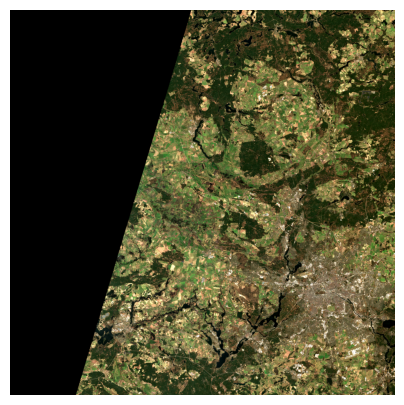

In [22]:
vis(rgb_arr, quant_norm=True)

### Course exercise

Create a [False Color Composite](https://en.wikipedia.org/wiki/False_color) by visualizing the bands `B8A`, `B04`, `B03`.
Try not use the `vis` function. If you have additional time, see what happens if you apply a _manual min-max_ normalization instead!

Note: We will talk about the meaning and application of false color composites in the future. For now, the goal is to familiarize yourself with `numpy`, matrix-operations, and visualization.


In [23]:
# false color
# 1.rivers 2. urban area & vegetatiion
rgb_arr_exe = np.stack(
    [s2_reader.read_band(b) for b in ("B8A_60m", "B04_60m", "B03_60m")],
    axis=-1,
)

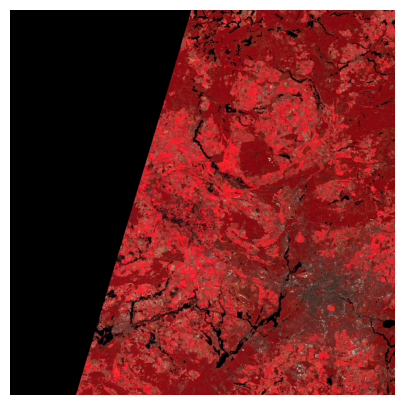

In [24]:
# with quantile normalization
vis(rgb_arr_exe, quant_norm=True)

## Copernicus API

Take a look at [Copernicus Dataspace](https://dataspace.copernicus.eu/) and make sure you have created an account and have the correct log-in data available. If you haven't already:
1. Sign up for the service 
2. Confirm the registration e-mail

In the following section, we will access the service over its [API](https://en.wikipedia.org/wiki/API).

To view the different tile data we don't need the access token, but to later download a tile, we need it. 
The token is valid for only 1 hour, so we cannot reuse it between sessions and have to create it new each time.

In [27]:
import requests
from pathlib import Path

def get_access_token(username: str, password: str) -> str:
    """
    Get the access token for the Copernicus Data Store. This token is required to access the data for download.
    The token is not required for querying the data. It is valid for 3600 seconds (1 hour).

    ----------
    username : str
        The username for the Copernicus Data Store.
    password : str
        The password for the Copernicus Data Store.
    """
    data = {
        "client_id": "cdse-public",
        "username": username,
        "password": password,
        "grant_type": "password",
    }
    try:
        r = requests.post(
            "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
            data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Access token creation failed. Response from the server was: {r.json()}"
        )
    return r.json()["access_token"]

# you may enter the credentials directly in your notebook
user_name = "siyux1927@gmail.com"
password = "Adela2012!Cleo2020!"

# the following code is for us to not have to share our secrets ;)
user_p = Path("user.txt")
pwd_p = Path("secret.txt")
if user_p.exists():
    user_name = user_p.read_text().strip()
if pwd_p.exists():
    password = pwd_p.read_text().strip()

assert user_name != "", "Please provide your user-name!"
assert password != "", "Please provide your password!"

# return the access token
access_token = get_access_token(user_name, password)

In [28]:
import pandas as pd
from typing import Optional, Iterable, Tuple

def dataspace_dataframe_from_attributes(
    collection: str = "SENTINEL-2",
    aoi: Optional[str] = None,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    attributes: Optional[Iterable[Tuple[str, str, float]]] = None,
    max_returned_items: int = 20
):
    """
    Get a dataframe of items from the Copernicus DataSpace API based on the given attributes.
    The request is build based on the OData standard as documented at
    https://documentation.dataspace.copernicus.eu/APIs/OData.html

    Parameters
    ----------
    collection : str
        The collection to search for. Default is "SENTINEL-2".
    aoi : str, optional
        The area of interest in WKT format. Default is None.
    start_date : str, optional
        The start date in the format "YYYY-MM-DD". Default is None.
    end_date : str, optional
        The end date in the format "YYYY-MM-DD". Default is None.
    attributes : Iterable[Tuple[str, str, float]], optional
        The attributes to filter by. Default is None which means no filtering and is equivalent to an empty list.
        Each tuple should be in the format (key, comparison, value).
        The comparison should be one of "lt", "le", "eq", "ge", "gt".
        Currently only attributes of type double and that are comparable are supported.
    max_returned_items : int, optional
        The maximum number of items to return. Default is 20. Must be in [0, 1000].
    """
    if attributes is None:
        attributes = []
    request_str = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter="
    request_str += f"Collection/Name eq '{collection}'"
    if aoi is not None:
        request_str += f" and OData.CSC.Intersects(area=geography'SRID=4326;{aoi}')"
    if start_date is not None:
        request_str += f" and ContentDate/Start gt {start_date}T00:00:00.000Z"
    if end_date is not None:
        request_str += f" and ContentDate/Start lt {end_date}T00:00:00.000Z"
    for k, comp, v in attributes:
        assert comp in ["lt", "le", "eq", "ge", "gt"]
        request_str += f" and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq '{k}' and att/OData.CSC.DoubleAttribute/Value {comp} {v:.2f})"
    # get all attributes
    request_str += "&$expand=Attributes"
    # get top n items
    assert 0 <= max_returned_items <= 1000, f"Copernicus API only allows returned items in [0, 1000], but {max_returned_items} is outside this range."
    request_str += f"&$top={max_returned_items}"
    json_result = requests.get(request_str).json()
    json_vals = json_result['value']
    return pd.DataFrame.from_dict(json_result['value'])

In [29]:
dataspace_dataframe_from_attributes(attributes=[('cloudCover', 'le', 40)], max_returned_items=1)['Attributes'].iloc[0]

[{'@odata.type': '#OData.CSC.StringAttribute',
  'Name': 'origin',
  'Value': 'CLOUDFERRO',
  'ValueType': 'String'},
 {'@odata.type': '#OData.CSC.StringAttribute',
  'Name': 'tileId',
  'Value': '33SXA',
  'ValueType': 'String'},
 {'@odata.type': '#OData.CSC.DoubleAttribute',
  'Name': 'cloudCover',
  'Value': 0.0,
  'ValueType': 'Double'},
 {'@odata.type': '#OData.CSC.IntegerAttribute',
  'Name': 'orbitNumber',
  'Value': 319,
  'ValueType': 'Integer'},
 {'@odata.type': '#OData.CSC.StringAttribute',
  'Name': 'orbitDirection',
  'Value': 'DESCENDING',
  'ValueType': 'String'},
 {'@odata.type': '#OData.CSC.StringAttribute',
  'Name': 'productGroupId',
  'Value': 'GS2A_20150715T094306_000319_N02.04',
  'ValueType': 'String'},
 {'@odata.type': '#OData.CSC.StringAttribute',
  'Name': 'processingLevel',
  'Value': 'S2MSI2A',
  'ValueType': 'String'},
 {'@odata.type': '#OData.CSC.StringAttribute',
  'Name': 'processorVersion',
  'Value': '02.05',
  'ValueType': 'String'},
 {'@odata.type': 

In [18]:
dataspace_dataframe_from_attributes()['Attributes'].iloc[0]

[{'@odata.type': '#OData.CSC.StringAttribute',
  'Name': 'origin',
  'Value': 'CLOUDFERRO',
  'ValueType': 'String'},
 {'@odata.type': '#OData.CSC.StringAttribute',
  'Name': 'tileId',
  'Value': '33SXA',
  'ValueType': 'String'},
 {'@odata.type': '#OData.CSC.DoubleAttribute',
  'Name': 'cloudCover',
  'Value': 0.0,
  'ValueType': 'Double'},
 {'@odata.type': '#OData.CSC.IntegerAttribute',
  'Name': 'orbitNumber',
  'Value': 319,
  'ValueType': 'Integer'},
 {'@odata.type': '#OData.CSC.StringAttribute',
  'Name': 'orbitDirection',
  'Value': 'DESCENDING',
  'ValueType': 'String'},
 {'@odata.type': '#OData.CSC.StringAttribute',
  'Name': 'productGroupId',
  'Value': 'GS2A_20150715T094306_000319_N02.04',
  'ValueType': 'String'},
 {'@odata.type': '#OData.CSC.StringAttribute',
  'Name': 'processingLevel',
  'Value': 'S2MSI2A',
  'ValueType': 'String'},
 {'@odata.type': '#OData.CSC.StringAttribute',
  'Name': 'processorVersion',
  'Value': '02.05',
  'ValueType': 'String'},
 {'@odata.type': 

---

We can see that key-word arguments and attributes can be provided. The attributes are filtered server-side. Right now, only attributes of type double are supported. To see the attributes of a certain product, you have to look into the `'Attributes'`-column of the respective data frame. Not all products have all attributes assigned.

To access a range for an attribute, two values have to be inserted, once with upper and once with lower bound

### Course exercise
Given the available information, construct a query that has the following properties:
- Start date is `2023-10-30` and end date is `2023-10-31`
- Cloud coverage is between 1.5 and 3.2
- Satellite Platform: `SENTINEL-2`

You should get back 351 query results.

In [35]:
from datetime import date
start_date = date(year=2023, month=10, day=30)
end_date = date(year=2023, month=10, day=31)
satellite = "SENTINEL-2"

products = dataspace_dataframe_from_attributes(
    collection=satellite,
    start_date=start_date.strftime("%Y-%m-%d"),
    end_date=end_date.strftime("%Y-%m-%d"),
    attributes=[('cloudCover', 'ge', 1.5),('cloudCover', 'le', 2.2)],
    max_returned_items=1000, # default
)


In [36]:
assert len(products) == 351, f"Expected 351 results, got {len(products)}"

In [37]:
products.head(3)

@odata.mediaContentType                                    Id   
0  application/octet-stream  74bc5d3a-ca90-4947-b727-fe6830493e8d  \
1  application/octet-stream  b8addd30-860f-448d-a8ef-9e817bb2c111   
2  application/octet-stream  8294fc1b-1e0a-483a-b5b8-72e1ea1db18e   

                                                Name   
0  S2B_MSIL2A_20231030T055949_N0509_R091_T42RWU_2...  \
1  S2B_MSIL2A_20231030T023829_N0509_R089_T51TWN_2...   
2  S2A_MSIL2A_20231030T014801_N0509_R017_T54UWC_2...   

                ContentType  ContentLength                OriginDate   
0  application/octet-stream     1219240539  2023-10-30T09:21:34.205Z  \
1  application/octet-stream      654682502  2023-10-30T05:48:07.820Z   
2  application/octet-stream      954276018  2023-10-30T05:42:37.647Z   

            PublicationDate          ModificationDate  Online EvictionDate   
0  2023-10-30T17:25:00.928Z  2024-03-14T10:05:12.898Z    True               \
1  2023-10-30T05:54:59.320Z  2024-03-14T10:04:27.023Z    True                
2  2023-10-30T05:54:53.758Z  2024-03-14T10:04:27.857Z    True                

                                              S3Path   
0  /eodata/Sentinel-2/MSI/L2A/2023/10/30/S2B_MSIL...  \
1  /eodata/Sentinel-2/MSI/L2A/2023/10/30/S2B_MSIL...   
2  /eodata/Sentinel-2/MSI/L2A/2023/10/30/S2A_MSIL...   

                                            Checksum   
0  [{'Value': 'd45af90a6558a1e5d4a73fb4e1ae0a04',...  \
1  [{'Value': '84feb1b905fa8fd2ae432515d3cd8050',...   
2  [{'Value': '63b3bc4e495648dbea8ccf41acd2766e',...   

                                         ContentDate   
0  {'Start': '2023-10-30T05:59:49.024Z', 'End': '...  \
1  {'Start': '2023-10-30T02:38:29.024Z', 'End': '...   
2  {'Start': '2023-10-30T01:48:01.024Z', 'End': '...   

                                           Footprint   
0  geography'SRID=4326;POLYGON ((68.9997910811369...  \
1  geography'SRID=4326;POLYGON ((123.547072988658...   
2  geography'SRID=4326;POLYGON ((142.598495434639...   

                                        GeoFootprint   
0  {'type': 'Polygon', 'coordinates': [[[68.99979...  \
1  {'type': 'Polygon', 'coordinates': [[[123.5470...   
2  {'type': 'Polygon', 'coordinates': [[[142.5984...   

                                          Attributes  
0  [{'@odata.type': '#OData.CSC.StringAttribute',...  
1  [{'@odata.type': '#OData.CSC.StringAttribute',...  
2  [{'@odata.type': '#OData.CSC.StringAttribute',...

To make it easier to work with the data, we will transform it from a [pandas](https://pandas.pydata.org/) [DataFrame](https://pandas.pydata.org/docs/user_guide/index.html), into a DataFrame that is aware of geographical meta-data and shapes, [geopandas](https://geopandas.org/en/stable/).

In [38]:
import geopandas as gpd

def copernicus_df_to_gdf(copernicus_df: pd.DataFrame, strftime: Optional[str] = None) -> gpd.GeoDataFrame:
    if strftime is not None and strftime.lower() in ['iso', 'iso 8601', 'default']:
        strftime = '%Y-%m-%dT%H:%M:%S'
    df = copernicus_df.copy()
    # split footprint into geometry (wkt text) and crs
    # 在地理信息系统（GIS）中，footprint 通常表示一个区域的边界，可以用 WKT（Well-Known Text）格式表示几何信息，同时需要一个 CRS 来定义坐标系。
    # assign crs
    crss = df['Footprint'].apply(lambda x: "EPSG:"+x.split(';')[0].split("'")[1].split('=')[1]) # e.g. 4326
    assert len(crss.unique()) == 1, "Multiple CRS values in data frame, geopandas can't handle that."
    # assign geometry
    df['geometry'] = gpd.GeoSeries.from_wkt(df['Footprint'].apply(lambda x: x.split(';')[1].split("'")[0]), crs=crss.iloc[0])
    gdf = gpd.GeoDataFrame(df)
    attribute_names = set(sl['Name'] for l in gdf['Attributes'] for sl in l)
    ignored_date_conversions = []
    successful_date_conversions = []
    for attr in attribute_names:
        gdf[attr] = gdf['Attributes'].apply(lambda x: [i for i in x if i['Name'] == attr][0]['Value'] if len([i for i in x if i['Name'] == attr]) > 0 else np.NaN)
    for attr in gdf.columns:
        if 'Date' in attr:
            # convert to DateTime
            try:
                gdf[attr] = pd.to_datetime(gdf[attr], yearfirst=True, format='mixed')
                # convert to numeric or string to make it json-serializable
                if strftime is None:
                    gdf[attr] = gdf[attr].values.astype(np.int64) // 10 ** 9
                else:
                    gdf[attr] = gdf[attr].dt.strftime(strftime)
            except Exception as e:
                ignored_date_conversions += [attr]
                continue
            successful_date_conversions += [attr]
    print(f"Ignored date conversions: {ignored_date_conversions}")
    print(f"Successful date conversions: {successful_date_conversions}")
    return gdf
    
gdf = copernicus_df_to_gdf(products, strftime='ISO')
gdf.explore() #!!

Ignored date conversions: ['ContentDate', 'sourceProductOriginDate']
Successful date conversions: ['OriginDate', 'PublicationDate', 'ModificationDate', 'EvictionDate', 'processingDate', 'endingDateTime', 'beginningDateTime']


In [39]:
# to only display the first 2
gdf.head(2)

@odata.mediaContentType                                    Id   
0  application/octet-stream  74bc5d3a-ca90-4947-b727-fe6830493e8d  \
1  application/octet-stream  b8addd30-860f-448d-a8ef-9e817bb2c111   

                                                Name   
0  S2B_MSIL2A_20231030T055949_N0509_R091_T42RWU_2...  \
1  S2B_MSIL2A_20231030T023829_N0509_R089_T51TWN_2...   

                ContentType  ContentLength           OriginDate   
0  application/octet-stream     1219240539  2023-10-30T09:21:34  \
1  application/octet-stream      654682502  2023-10-30T05:48:07   

       PublicationDate     ModificationDate  Online EvictionDate  ...   
0  2023-10-30T17:25:00  2024-03-14T10:05:12    True          NaN  ...  \
1  2023-10-30T05:54:59  2024-03-14T10:04:27    True          NaN  ...   

  platformSerialIdentifier tileId       endingDateTime   
0                        B  42RWU  2023-10-30T05:59:49  \
1                        B  51TWN  2023-10-30T02:38:29   

                             sourceProductOriginDate processingLevel   
0  2023-10-30T09:21:34.205Z,2023-10-30T08:13:05.005Z         S2MSI2A  \
1  2023-10-30T05:48:07.820Z,2023-10-30T05:01:07.549Z         S2MSI2A   

  instrumentShortName platformShortName    beginningDateTime orbitDirection   
0                 MSI        SENTINEL-2  2023-10-30T05:59:49     DESCENDING  \
1                 MSI        SENTINEL-2  2023-10-30T02:38:29     DESCENDING   

   operationalMode  
0         INS-NOBS  
1         INS-NOBS  

[2 rows x 39 columns]

In [40]:
# select a subset of the columns for clarity; these are way too many
gdf.columns

Index(['@odata.mediaContentType', 'Id', 'Name', 'ContentType', 'ContentLength',
       'OriginDate', 'PublicationDate', 'ModificationDate', 'Online',
       'EvictionDate', 'S3Path', 'Checksum', 'ContentDate', 'Footprint',
       'GeoFootprint', 'Attributes', 'geometry', 'cloudCover',
       'processingDate', 'orbitNumber', 'sourceProductHashBlake3',
       'datastripId', 'sourceProduct', 'granuleIdentifier', 'productType',
       'processorVersion', 'relativeOrbitNumber', 'origin', 'productGroupId',
       'platformSerialIdentifier', 'tileId', 'endingDateTime',
       'sourceProductOriginDate', 'processingLevel', 'instrumentShortName',
       'platformShortName', 'beginningDateTime', 'orbitDirection',
       'operationalMode'],
      dtype='object')

In [42]:
sub_gdf = gdf[["Name", "Id", "geometry"]]

### Geopandas

When you have a `GeoDataFrame` with a `geometry` column set (as provided by the `SentinelAPI`) you can quickly visualize your geographical data. This is one of the main benefits why we use `GeoDataFrame` over a simple Pandas `DataFrame`:

In [43]:
sub_gdf.head(5).explore()

In [44]:
sub_gdf.head(1).explore()

#### Geopandas in short

A [GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html#geopandas.GeoDataFrame) contains one special column and one _special_ property.
The _geometry_ column and the [CRS](https://en.wikipedia.org/wiki/Spatial_reference_system) column.

##### Geometries/Shapes

The geometry column contains _shapes_ in reference to [Coordinate Reference System](https://en.wikipedia.org/wiki/Spatial_reference_system).
Let's look at the geometry columns first:

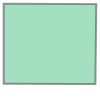

In [45]:
# by default it does some nice plotting
geometry = sub_gdf.iloc[0]["geometry"]
geometry

How is the data structure represented?

Simply by defining the type of shape (here `POLYGON` or `MultiPolygon`) and the X-Y coordinates of each point!

In [46]:
from pprint import pprint
# points
pprint(geometry.wkt)

('POLYGON ((68.99979108113692 30.73307003214313, 70.14665881519576 '
 '30.728004669372204, 70.13521789493299 29.73733482256821, 68.99979316619728 '
 '29.74220376506903, 68.99979108113692 30.73307003214313))')


Similar to [JSON](https://en.wikipedia.org/wiki/JSON) these shapes/geometries have their own file format(s) that are used to serialize/deserialize the data, called [WKT](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) (Well-known text representation of geometry).
The exact structure of the data format is not too important (nor their alternatives), the main thing to remember is that geometries may be defined by simple textual description, such as `POINT (30 10)` or `LINESTRING (30 10, 10 30, 40 40)`.

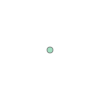

In [47]:
point = geometry.representative_point()
point

In [48]:
point.wkt

'POINT (69.5703792994844 30.235104217220616)'

##### Coordinate Reference System

Now let's take a quick look at the [Coordinate Reference System](https://en.wikipedia.org/wiki/Spatial_reference_system).
Confusingly, a popular format that is used to describe the coordinate reference system, is also called [WKT or WKT-CRS](https://en.wikipedia.org/wiki/Well-known_text_representation_of_coordinate_reference_systems) (Well-known text representation of coordinate reference systems):

In [49]:
print(sub_gdf.crs.to_wkt(pretty=True))

GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["Horizontal component of 3D system."],
        AREA["World."],
      

Most coordinate reference systems can also be encoded as an [EPSG code](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) which is a numerical value.

In [50]:
sub_gdf.crs.to_epsg()

4326

Again, it is not important to understand the data format in detail!
The main thing to remember is that in order to specify _any_ point in space, we not only need the coordinates but also information to what our axis/scale relate to.
For our use-cases the main number to remember is the EPSG code *4326* which is used to describe (Long, Lat) points on earth. 

#### Using GeoPandas with Copernicus

In [51]:
from datetime import date
from shapely.geometry import Point
import rasterio

from typing import Sequence
import matplotlib.pyplot as plt
import geopandas

Let's select a point of interest (POI).
For this lab we will use the TU Berlin building.

The following code requires the Latitude and Longitude coordinates of the POI.
For now, we can simply rely on a service like [LatLong.net](latlong.net) to look up the coordinates:

- [TU Berlin coordinates via LatLong.net](https://www.latlong.net/place/technical-university-of-berlin-germany-248.html)

In [53]:
latitude = 52.51388 # 纬度
longitude = 13.32593 # 精度

In [52]:
# a GeoSeries is just one data column of a GeoDataFrame
# or you can think of it as a series/list of geographical objects and a CRS
# ?geopandas.GeoSeries

In [54]:
series = geopandas.GeoSeries([Point(longitude, latitude)], crs="EPSG:4326")
series

0    POINT (13.32593 52.51388)
dtype: geometry

In [55]:
# GeoPandas allows us to very quickly visually inspect our geographical data
series.explore(marker_type="marker")

To query the copernicus database, we need to encode our geometry data into a common format that the service can understand.
Looking at the documentation of the query function, we can see that the API expect the data to be encoded as a WKT string.

In [56]:
series.to_wkt()

0    POINT (13.32593 52.51388)
dtype: object

In [57]:
poi = series.to_wkt()[0]
poi

'POINT (13.32593 52.51388)'

In [58]:
# 通过geoseries提取poi，应用到copernicus
start_date = date(year=2024, month=3, day=7)
end_date = date(year=2024, month=3, day=9)
satellite = "SENTINEL-2"

products = dataspace_dataframe_from_attributes(
    collection=satellite,
    start_date=start_date.strftime("%Y-%m-%d"),
    end_date=end_date.strftime("%Y-%m-%d"),
    aoi=poi,
    attributes=[('cloudCover', 'le', 40)]
)

# convert to GeoPandas GeoDataFrame
products_gdf = copernicus_df_to_gdf(products, strftime='iso')
assert not products_gdf.empty

Ignored date conversions: ['ContentDate', 'sourceProductOriginDate']
Successful date conversions: ['OriginDate', 'PublicationDate', 'ModificationDate', 'EvictionDate', 'processingDate', 'endingDateTime', 'beginningDateTime']


In [59]:
# sort and select the first row
product = products_gdf.sort_values(
    ["cloudCover", "PublicationDate"], ascending=[True, True]
).head(1)

In [60]:
# ensuring that the tile is the one we are also providing via a direct
# download link
expected_name = "S2A_MSIL1C_20240308T100841_N0510_R022_T32UQD_20240308T120958.SAFE"
assert product["Name"].iloc[0] == expected_name, f"Expected name: {expected_name}, but got name: {product['Name'].iloc[0]}" 

In [61]:
# Would fail, because there are entries that cannot be JSON encoded!
# product.explore()
# Only visualize the relevant columns and convert them if necessary, for us 'title', 'summary', and 'geometry' are sufficent
# if you exclude the geometry column, it cannot be drawn on the map!
product[["Name", "cloudCover", "geometry", 'OriginDate']].explore()

**Question**: Why does our tile look so oddly shaped? What does it mean? How is our data formatted? Does the _missing/invalid_ region have specific values?

### Selecting regions of tiles 

We can use the `osmnx` library to retrieve the area of interest by looking up a name-identifier.

In [62]:
import osmnx
import rasterio.mask

In [75]:
berlin_char_gdf = osmnx.geocode_to_gdf("Berlin, Charlottenburg")
berlin_char_gdf

geometry  bbox_north  bbox_south   
0  POLYGON ((13.28062 52.52426, 13.28073 52.52366...   52.532372   52.499021  \

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat        lon   
0  13.341429  13.280624  127934916  relation  110126  52.515747  13.309683  \

      class            type  place_rank  importance addresstype   
0  boundary  administrative          20    0.543331      suburb  \

             name                                       display_name  
0  Charlottenburg  Charlottenburg, Charlottenburg-Wilmersdorf, Be...

In [76]:
berlin_char_gdf.explore()

From this shape, we can create the bounding box

In [77]:
berlin_char_gdf_rect = berlin_char_gdf.envelope
berlin_char_gdf_rect.explore()

In [71]:
# ?rasterio.mask.mask

In [78]:
def read_s2_jp2_data_with_clipping(
    band_data_path: Path, clip_geoseries: geopandas.GeoSeries, envelope: bool = True
) -> np.ndarray:
    """
    Given the `band_data_path` to a JP2000 encoded GeoTIFF file, return those parts that are overlapping with the
    `clip_geoseries` GeoSeries. By default, the bounding box (`envelope`) of the geometry will be used to define the
    region of interest.
    """
    # open the GeoTIFF file which also contains the CRS metadata
    with rasterio.open(band_data_path) as data:
        # ensure that the data is using the same coordinate reference system and reproject if they don't
        reprojected_geoseries = clip_geoseries.to_crs(data.crs)
        # use the bounding box if `envelope` is set => Make sure that the matrix we get back can contain
        # only valid values
        reprojected_geoseries = (
            reprojected_geoseries.envelope if envelope else reprojected_geoseries
        )
        # Use crop to only return the matrix that contains our region of interest
        # Use `all_touched=True` to make sure that the border is also conisdered "inside" the region of interest
        out_img, _out_transform = rasterio.mask.mask(
            data, reprojected_geoseries, crop=True, all_touched=True
        )
        # drop singleton axes
        out_img = out_img.squeeze()
    return out_img

In [79]:
class S2TileReader:
    def __init__(self, directory: Path):
        """
        Initialize the reader with a directory containing the SAFE file of a Sentinel-2 product.

        Parameters
        ----------
        directory : Path
            The directory containing the SAFE file of a Sentinel-2 product.
        """
        assert directory.is_dir(), f"{directory} is not a directory"
        self.image_files = list(directory.glob(f"**/IMG_DATA/*.jp2"))
        if len(self.image_files) == 0:
            self.image_files = list(directory.glob(f"**/IMG_DATA/R60m/*.jp2"))
            self.image_files.extend(list(directory.glob(f"**/IMG_DATA/R20m/*.jp2")))
            self.image_files.extend(list(directory.glob(f"**/IMG_DATA/R10m/*.jp2")))
        self.band2file_mapping = self._bands()
        self.bands = sorted(self.band2file_mapping.keys())
        print(f"{len(self.band2file_mapping)} images found in {directory}")

    def _bands(self):
        """
        Extract the band names from the image files and create a mapping from band name to file path.

        Example:
        {
            "B01": Path("path/to/B01.jp2"),
            "B02": Path("path/to/B02.jp2"),
            ...
        }
        or if the product has multiple resolutions:
        {
            "B01_60m": Path("path/to/R60m/B01.jp2"),
            "B02_10m": Path("path/to/R10m/B02.jp2"),
            ...
        }
        """
        return {"_".join(x.stem.split("_")[2:]):x for x in self.image_files}

    def read_band(self, band: str):
        """
        Read the data of a specific band. The data is returned as a numpy array. If the band is a single channel,
        the array will have shape (height, width). If the band is a multi-channel band, the array will have shape
        (height, width, channels).

        Parameters
        ----------
        band : str
            The name of the band to read. Must be one of the bands in the product.
            Use the `bands` attribute to see the available bands.
        """
        assert band in self.bands, f"Band {band} invalid. Please select one of {self.bands}"
        img_path = self.band2file_mapping[band]
        with rasterio.open(self.band2file_mapping[band]) as f:
            data = f.read()
        if data.shape[0] == 1:
            return data.squeeze(0)
        elif data.shape[0] == 3:
            return np.transpose(data, (1, 2, 0))

    ###

    # Add new reading band with clipping function
    def read_band_data_with_clipping(
        self, band: str, clip_geoseries: geopandas.GeoSeries, envelope: bool = True
    ) -> np.ndarray:
        assert band in self.bands, f"Band {band} invalid. Please select one of {self.bands}"
        img_path = self.band2file_mapping[band]
        return read_s2_jp2_data_with_clipping(img_path, clip_geoseries, envelope=envelope)


# re-initialize
s2_reader = S2TileReader(unzipped_dir)
band03_data = s2_reader.read_band("B03_10m")
band03_data.shape

36 images found in data/S2A_MSIL2A_20240308T100841_N0510_R022_T33UUU_20240308T143352.SAFE


(10980, 10980)

In [80]:
clipped_band03_data = s2_reader.read_band_data_with_clipping(
    "B03_10m", berlin_char_gdf.geometry, envelope=True
)
clipped_band03_data.shape

(370, 411)

In [81]:
clipped_rgb_arr = np.stack(
    [
        s2_reader.read_band_data_with_clipping(b, berlin_char_gdf.geometry)
        for b in ("B04_10m", "B03_10m", "B02_10m")
    ],
    axis=-1,
)

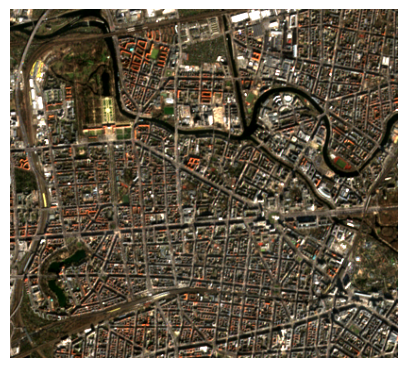

In [82]:
vis(clipped_rgb_arr, quant_norm=True)

## Inspecting spectral signature

In [83]:
# LCLU: Land-Cover Land-Use
lclu_gdf = geopandas.GeoDataFrame(
    {"type": ["water", "airport", "forest"]},
    geometry=[
        # Took the points from latlong.net
        Point(13.175955, 52.456009),
        Point(13.508517, 52.380236),
        Point(13.212926, 52.478834),
    ],
    crs="epsg:4326",
)
lclu_gdf.reset_index().explore(marker_type="marker")

In [84]:
# depends on product type and used image directory!
AVAILABLE_BANDS = (
    "B01_20m",
    "B02_10m",
    "B03_10m",
    "B04_10m",
    "B05_60m",
    "B06_20m",
    "B07_20m",
    "B08_10m",
    "B09_60m",
    "B11_20m",
    "B12_20m",
    "B8A_20m",
)


def read_points_from_tile(
    s2_reader: S2TileReader,
    points_series: geopandas.GeoSeries,
    bands: Sequence[str] = AVAILABLE_BANDS,
) -> np.ndarray:
    if set(lclu_gdf.geom_type) != {"Point"}:
        raise ValueError("Only point geometries are allowed!")

    return np.array([s2_reader.read_band_data_with_clipping(b, points_series) for b in bands])

In [85]:
lclu_gdf

type                   geometry
0    water  POINT (13.17596 52.45601)
1  airport  POINT (13.50852 52.38024)
2   forest  POINT (13.21293 52.47883)

In [86]:
# example of pandas `query` command
water_spectral_sig = read_points_from_tile(s2_reader, lclu_gdf.query("type == 'water'"))
airport_spectral_sig = read_points_from_tile(
    s2_reader, lclu_gdf.query("type == 'airport'").geometry
)
forest_spectral_sig = read_points_from_tile(s2_reader, lclu_gdf.query("type == 'forest'").geometry)

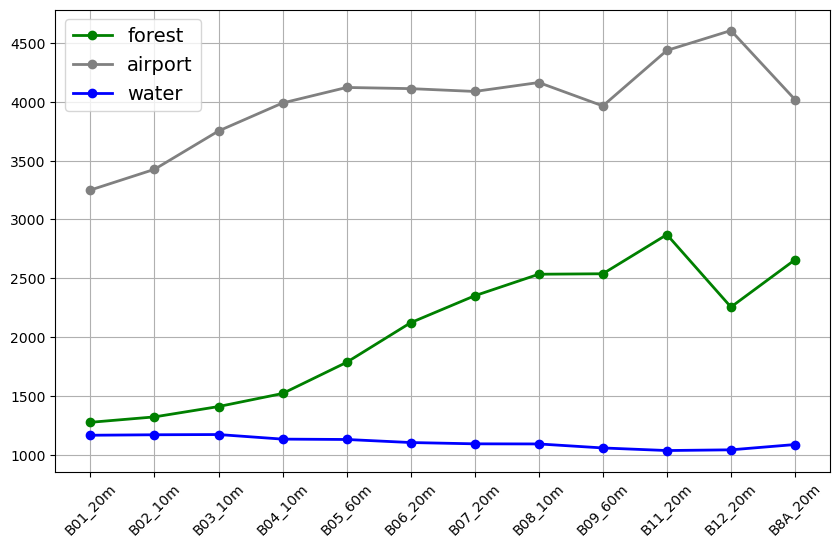

In [87]:
# The following figure takes a very naïve approach and assumes that the selected pixels are noise free, high-resolution, etc.
# but it is sufficient to get a clear understanding of general form of different spectral reflectance curves.
plt.figure(figsize=(10, 6))
plt.plot(AVAILABLE_BANDS, forest_spectral_sig, "o-", label="forest", linewidth=2, color="green")
plt.plot(AVAILABLE_BANDS, airport_spectral_sig, "o-", label="airport", linewidth=2, color="gray")
plt.plot(AVAILABLE_BANDS, water_spectral_sig, "o-", label="water", linewidth=2, color="blue")

plt.legend(fontsize=14)
plt.xticks(rotation=45)
plt.grid()

### Course exercise

Select 3 different point (pixels) and plot their spectral signitures.
Select those points either by using [LatLong.net](latlong.net) or using the `osmx` library and applying the correct function to the geometries to get a `Point`.

Feel free to play around with the variuous different GeoDataFrame functions as well.